# Module Import

In [2]:
import pandas as pd
import numpy as np
import openpyxl

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# pandas 경고 무시
pd.set_option('mode.chained_assignment',  None)

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# Data Load

In [3]:
data = pd.read_csv('../data/행정자치부 공공데이터 숙박업 등록현황.csv', encoding = 'cp949')
# 데이터 출처 : 공공데이터포털 / 행정안전부_숙박업 데이터
# https://www.data.go.kr/data/15044968/fileData.do
print(data.shape)
data.head()

(54051, 51)


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,조건부허가시작일자,조건부허가종료일자,건물소유구분명,세탁기수,여성종사자수,남성종사자수,회수건조수,침대수,다중이용업소여부,Unnamed: 50
0,1,숙박업,03_11_03_P,3620000,3620000-201-2005-00005,20050818,NaN,1,영업/정상,1,...,NaN,NaN,임대,0.0,NaN,NaN,0.0,0.0,N,NaN
1,2,숙박업,03_11_03_P,3620000,3620000-201-2000-00013,20000615,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN
2,3,숙박업,03_11_03_P,3620000,3620000-214-1985-00002,19851119,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
3,4,숙박업,03_11_03_P,3620000,3620000-201-2000-00014,20000710,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
4,5,숙박업,03_11_03_P,3620000,3620000-201-2002-00007,20020429,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN


# Data Preprocessing

In [4]:
# 영업중인 숙박시설만 추출
df = data[data['상세영업상태명']=="영업"]

# 필요한 열만 추출 
df = df[['사업장명','업태구분명', '인허가일자']]

# 인허가일자 중 연도만 추출
df['인허가일자'] = df['인허가일자'].apply(lambda x: str(x)[:4])
df['인허가일자'] = df['인허가일자'].astype(int)

# 2022년 데이터 제거
df = df[df['인허가일자']<2022]

df = df.rename(columns={'사업장명':'name', '업태구분명':'type', '인허가일자':'year'})

In [5]:
# 숙박업 유형 변경
def hoteltype(x):
    if x == '숙박업(생활)':
        return '생활형숙박시설'
    else:
        return '일반숙박시설'

In [6]:
df['type'] = df['type'].apply(hoteltype)
df.head()

,name,type,year
0,야자,일반숙박시설,2005
1,엔(N)모텔,일반숙박시설,2000
2,디오앤에스임동,생활형숙박시설,1985
3,에로스모텔,일반숙박시설,2000
4,클라우드인호텔,일반숙박시설,2002


In [7]:
# 일반숙박시설과 생활형숙박시설 분리

df_normal = df[df['type']=='일반숙박시설']
df_residence = df[df['type']=='생활형숙박시설']
display(df_normal.head())
display(df_residence.head())

#2010년 이후 데이터만 추출
after2010 = df[df['year']>=2010]
after2010_normal = after2010[after2010['type']=='일반숙박시설']
after2010_residence = after2010[after2010['type']=='생활형숙박시설']

,name,type,year
0,야자,일반숙박시설,2005
1,엔(N)모텔,일반숙박시설,2000
3,에로스모텔,일반숙박시설,2000
4,클라우드인호텔,일반숙박시설,2002
5,다빈치모텔,일반숙박시설,2000


,name,type,year
2,디오앤에스임동,생활형숙박시설,1985
12,실크로드,생활형숙박시설,1985
299,경주게스트하우스,생활형숙박시설,1995
329,씨엘미니호텔,생활형숙박시설,1989
330,청춘게스트하우스 호스텔,생활형숙박시설,2017


In [8]:
year_list = list(np.arange(2010,2022,1))*2
type_list = ['일반숙박시설']*12+['생활형숙박시설']*12
count_list = list(after2010_normal.groupby('year')['type'].count()) + list(after2010_residence.groupby('year')['type'].count())
cumsum_list = list(after2010_normal.groupby('year')['type'].count().cumsum()) + list(after2010_residence.groupby('year')['type'].count().cumsum())

In [9]:
df_count = pd.DataFrame({'year':year_list, 'type':type_list, 'price':count_list, 'cumsum':cumsum_list})
df_count

,year,type,price,cumsum
0,2010,일반숙박시설,336,336
1,2011,일반숙박시설,350,686
2,2012,일반숙박시설,404,1090
3,2013,일반숙박시설,450,1540
4,2014,일반숙박시설,539,2079
5,2015,일반숙박시설,550,2629
6,2016,일반숙박시설,485,3114
7,2017,일반숙박시설,571,3685
8,2018,일반숙박시설,447,4132
9,2019,일반숙박시설,365,4497


In [10]:
x = np.arange(12)
y_normal= list(after2010_normal.groupby('year')['type'].count().cumsum())
y_residence = list(after2010_residence.groupby('year')['type'].count().cumsum())
lst_normal = pd.DataFrame({'x':x, 'y':y_normal})
lst_residence = pd.DataFrame({'x':x, 'y':y_residence})

- Regression Fitting (Prediction)

In [11]:
# 일반숙박시설 업체수 2차 회귀식 적합

model_normal = smf.ols("y_normal~x+np.square(x)", data=lst_normal).fit()
model_normal.summary()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               y_normal   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1190.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.24e-11
Time:                        16:34:20   Log-Likelihood:                -72.085
No. Observations:                  12   AIC:                             150.2
Df Residuals:                       9   BIC:                             151.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      181.0577     83.940      2.157      0.059      -8.828     370.943
x              515.1451     35.476     14.521      0.000     434.893     595.397
np.square(x)    -4.7535      3.107     -1.530      0.160     -11.783       2.276
==============================================================================
Omnibus:                        1.722   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                0.890
Skew:                           0.222   Prob(JB):                        0.641
Kurtosis:                       1.742   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# 생활형숙박시설 업체수 2차 회귀식 적합

model_residence = smf.ols("y_residence~x+np.square(x)", data=lst_residence).fit()
model_residence.summary()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            y_residence   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7101.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           4.05e-15
Time:                        16:34:20   Log-Likelihood:                -57.580
No. Observations:                  12   AIC:                             121.2
Df Residuals:                       9   BIC:                             122.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       79.9890     25.060      3.192      0.011      23.299     136.679
x               94.6828     10.591      8.940      0.000      70.723     118.642
np.square(x)    21.5120      0.928     23.188      0.000      19.413      23.611
==============================================================================
Omnibus:                        0.303   Durbin-Watson:                   2.495
Prob(Omnibus):                  0.859   Jarque-Bera (JB):                0.442
Skew:                          -0.226   Prob(JB):                        0.802
Kurtosis:                       2.176   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# 회귀식을 바탕으로 하여 예측값 계산

def quadratic_normal(x):
    return model_normal.params['np.square(x)']*x**2 + model_normal.params['x']*x + model_normal.params['Intercept']
def quadratic_residence(x):
    return model_residence.params['np.square(x)']*x**2 + model_residence.params['x']*x + model_residence.params['Intercept']

In [14]:
# 2025년까지의 예측값 추가

x = np.arange(2010,2026)

for i in range(12,16):
    y_normal.append(round(quadratic_normal(i)))
    y_residence.append(round(quadratic_residence(i)))

In [15]:
lst_normal = pd.DataFrame({'x':x, 'y':y_normal})
lst_residence = pd.DataFrame({'x':x, 'y':y_residence})

In [16]:
count_normal = list(after2010_normal.groupby('year')['type'].count())
count_residence = list(after2010_residence.groupby('year')['type'].count())

In [17]:
for i in range(11,15):
    count_normal.append(quadratic_normal(i+1) - y_normal[i])
    count_residence.append(quadratic_residence(i+1) - y_residence[i])

In [18]:
year_list = list(np.arange(2010,2026,1))*2
type_list = ['일반숙박시설']*16+['생활형숙박시설']*16
count_list = list(count_normal) + list(count_residence)
cumsum_list = y_normal+y_residence

In [19]:
df_pred = pd.DataFrame({'year':year_list, 'type':type_list, 'count':count_list, 'cumsum':cumsum_list})

In [20]:
df_pred

,year,type,count,cumsum
0,2010,일반숙박시설,336.000000,336
1,2011,일반숙박시설,350.000000,686
2,2012,일반숙박시설,404.000000,1090
3,2013,일반숙박시설,450.000000,1540
4,2014,일반숙박시설,539.000000,2079
5,2015,일반숙박시설,550.000000,2629
6,2016,일반숙박시설,485.000000,3114
7,2017,일반숙박시설,571.000000,3685
8,2018,일반숙박시설,447.000000,4132
9,2019,일반숙박시설,365.000000,4497


In [21]:
df_ratio = pd.DataFrame({'year':np.arange(2010,2022), 'value': list(after2010[after2010['type']=="생활형숙박시설"].groupby('year')[['name']].count()['name']/after2010.groupby('year')[['name']].count()['name'])})

# Data Visualization

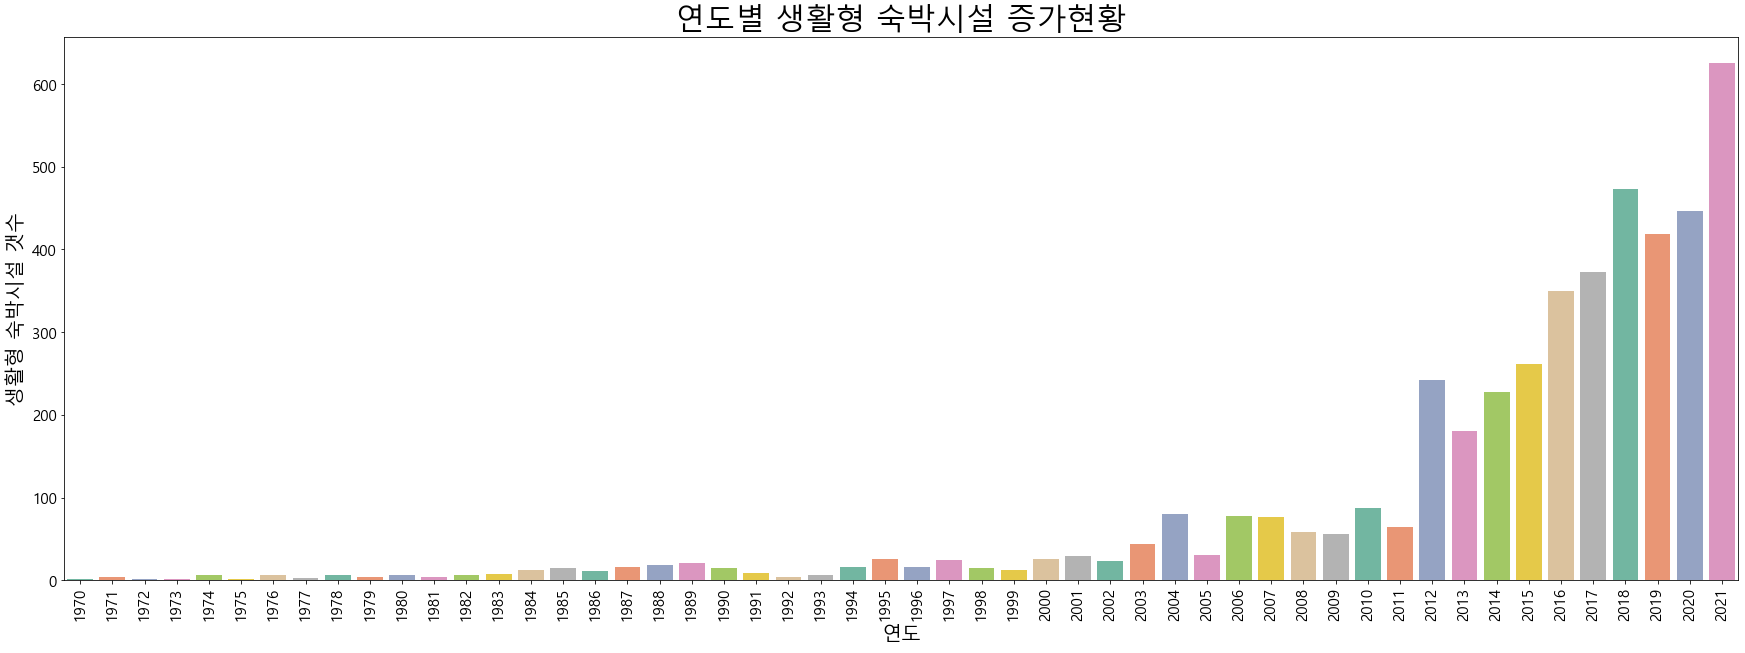

In [35]:
plt.figure(figsize=(30,10))
sns.countplot(x='year', data=df_residence, palette='Set2', order = sorted(df_residence['year'].unique()))
plt.title('연도별 생활형 숙박시설 증가현황', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('생활형 숙박시설 갯수', fontsize=20)
plt.xticks(rotation=90)
plt.show()

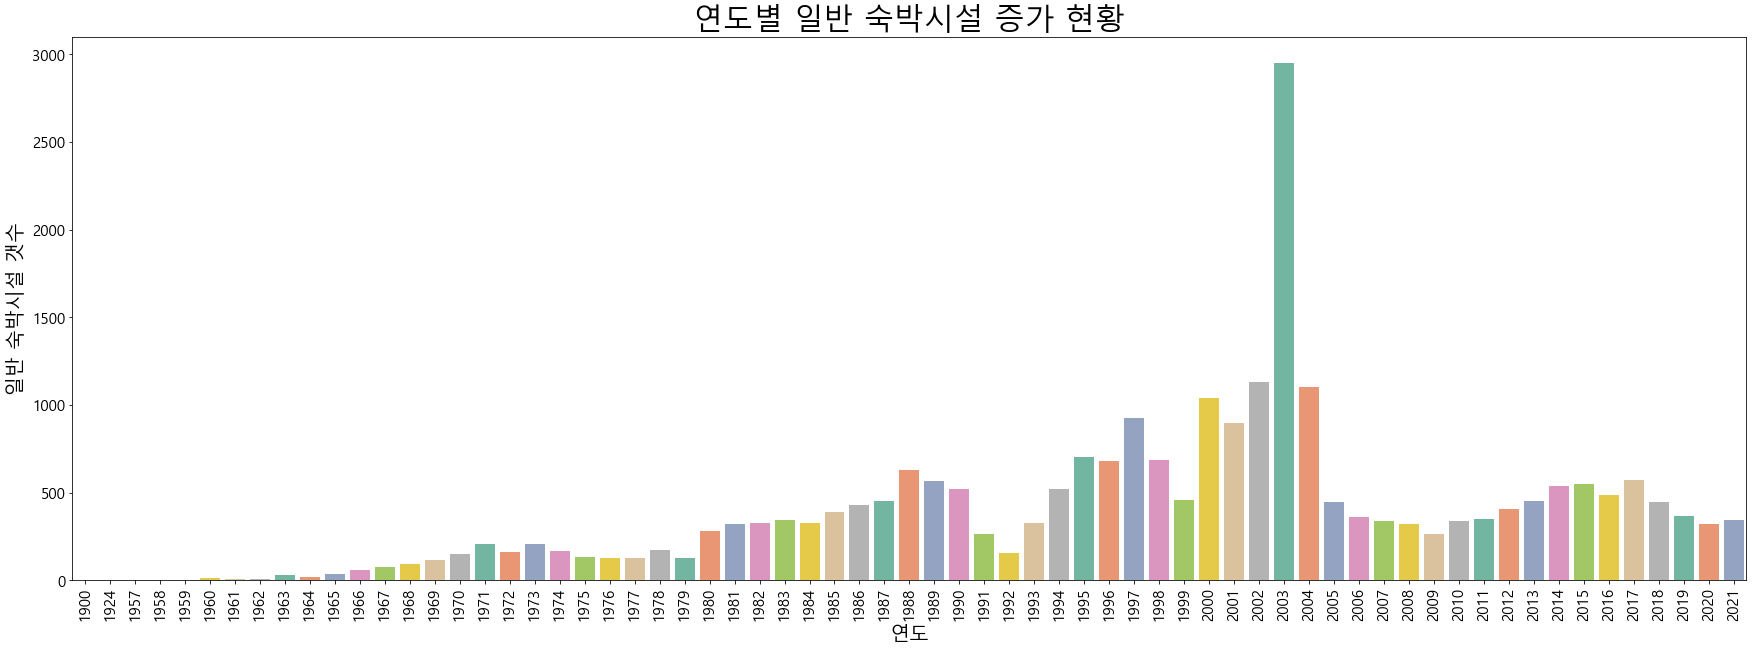

In [36]:
plt.figure(figsize=(30,10))
sns.countplot(x='year', data=df_normal, palette='Set2', order = sorted(df_normal['year'].unique()))
plt.title('연도별 일반 숙박시설 증가 현황', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('일반 숙박시설 갯수', fontsize=20)
plt.xticks(rotation=90)
plt.show()

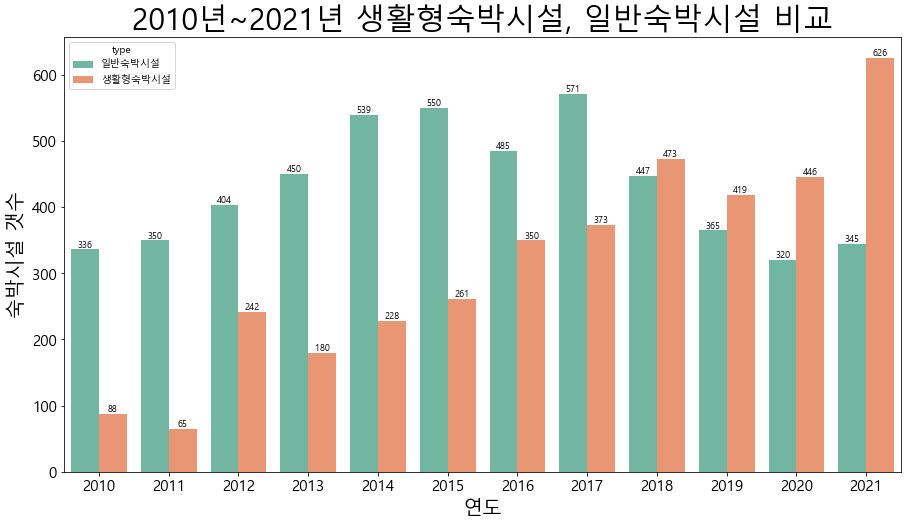

In [37]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='year', data=after2010, palette='Set2', hue="type", dodge = True, order = sorted(after2010['year'].unique()))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
    
plt.title('2010년~2021년 생활형숙박시설, 일반숙박시설 비교', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('숙박시설 갯수', fontsize=20)
# plt.xticks(rotation=90)
plt.show()

In [22]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)

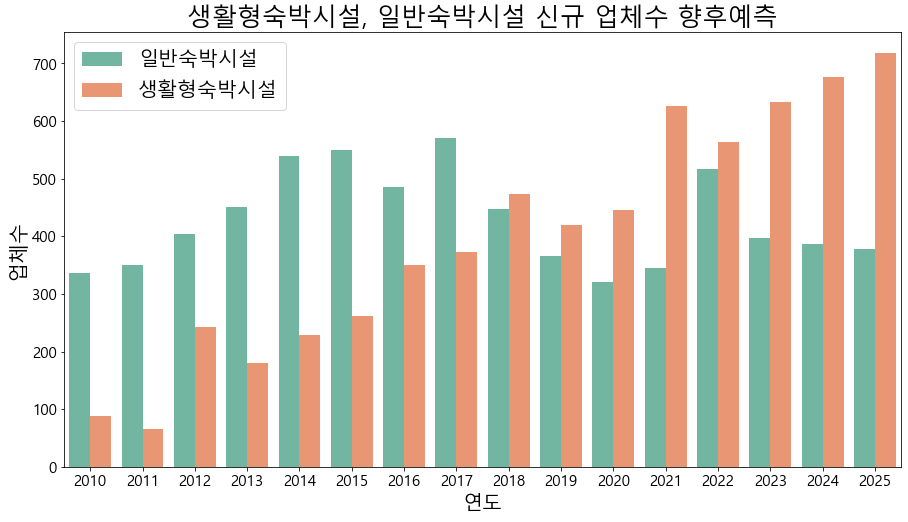

In [23]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_pred, x="year", y="count", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 신규 업체수 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('업체수', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

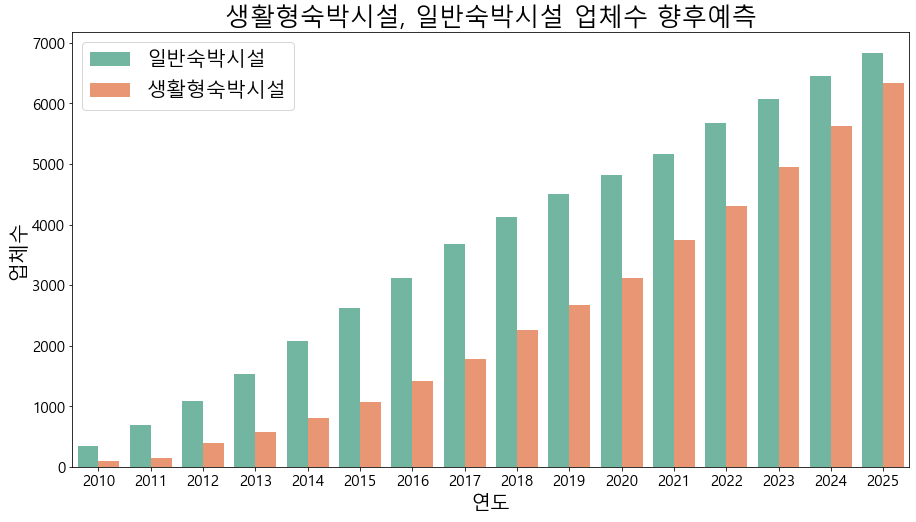

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_pred, x="year", y="cumsum", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 업체수 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('업체수', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

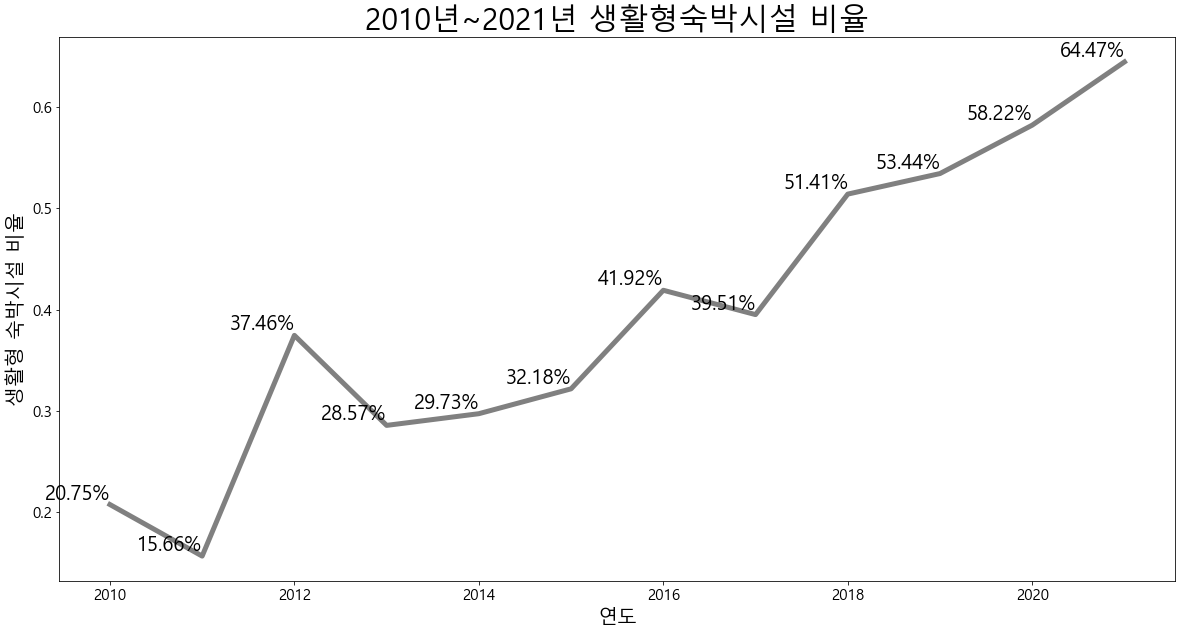

In [25]:
plt.figure(figsize=(20,10))
plt.plot("year", "value", data=df_ratio, linewidth=5, color='grey')
x = df_ratio['year']
y = df_ratio['value']

for i, v in enumerate(x):
    plt.text(v, y[i], str(round(y[i]*100,2))+'%',                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 20, 
             color='black',
             horizontalalignment='right',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title('2010년~2021년 생활형숙박시설 비율', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('생활형 숙박시설 비율', fontsize=20)
plt.show()

# Time-Series

In [76]:
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import itertools

In [77]:
residence_ts = pd.DataFrame({'day': list(sorted(data_residence['인허가일자'].unique())), 'count': list(data_residence.groupby('인허가일자')['사업장명'].count())})

In [78]:
residence_ts['day'] = residence_ts['day'].astype(str)
residence_ts['day'] = pd.to_datetime(residence_ts['day'])

In [79]:
residence_ts.index = residence_ts['day']
residence_ts.set_index('day', inplace=True)
residence_ts.head()

,count
day,
1970-01-01,2
1971-01-01,4
1972-01-01,2
1973-01-01,2
1974-01-01,6


- data preprocessing

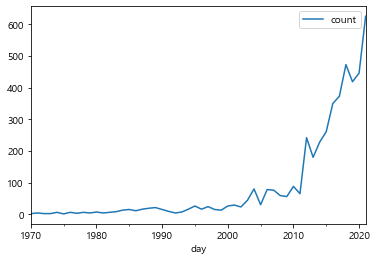

In [80]:
fig = residence_ts.plot()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


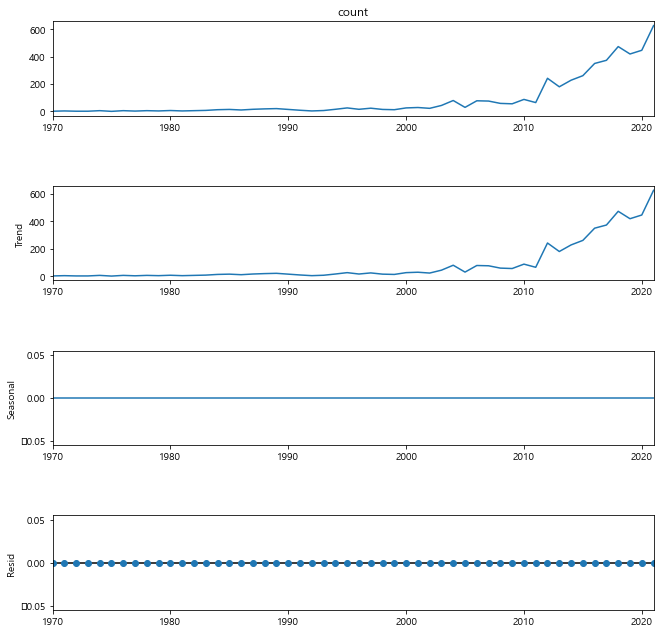

In [81]:
decomposition = sm.tsa.seasonal_decompose(residence_ts['count'], model = 'additive', period = 1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

- identify model to be tentatively entertained

In [82]:
train_data, test_data = train_test_split(residence_ts, test_size = 0.1, shuffle = False)

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


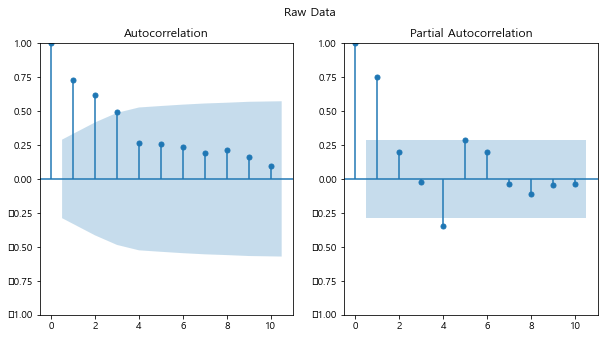

In [83]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=10, ax=ax[1])
plt.show()

In [84]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['count'].diff()
diff_train_data = diff_train_data.dropna()
print('########## RAW DATA ##########')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

########## RAW DATA ##########
            count
day              
1970-01-01      2
1971-01-01      4
1972-01-01      2
1973-01-01      2
1974-01-01      6
1975-01-01      1
1976-01-01      6
1977-01-01      3
1978-01-01      6
1979-01-01      4
1980-01-01      7
1981-01-01      4
1982-01-01      6
1983-01-01      8
1984-01-01     13
1985-01-01     15
1986-01-01     11
1987-01-01     16
1988-01-01     19
1989-01-01     21
1990-01-01     15
1991-01-01      9
1992-01-01      4
1993-01-01      7
1994-01-01     16
1995-01-01     26
1996-01-01     16
1997-01-01     24
1998-01-01     15
1999-01-01     13
2000-01-01     26
2001-01-01     29
2002-01-01     23
2003-01-01     44
2004-01-01     80
2005-01-01     30
2006-01-01     78
2007-01-01     76
2008-01-01     59
2009-01-01     56
2010-01-01     88
2011-01-01     65
2012-01-01    242
2013-01-01    180
2014-01-01    228
2015-01-01    261
### Differenced Data ###
day
1971-01-01      2.0
1972-01-01     -2.0
1973-01-01      0.0
1974-01-01      

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


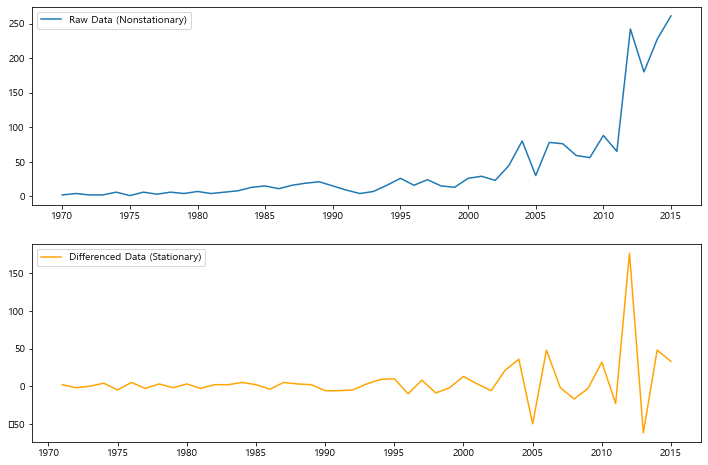

In [85]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['count'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


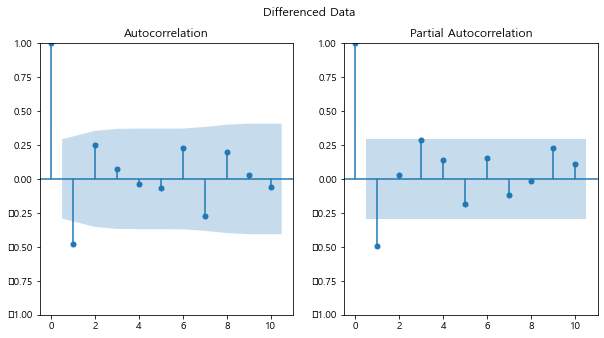

In [86]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=10, ax=ax[1])
plt.show()

- Estimate parameters

In [87]:
model = ARIMA(train_data.values, order = (1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -215.867
Date:                Tue, 15 Feb 2022   AIC                            435.734
Time:                        18:22:55   BIC                            439.348
Sample:                             0   HQIC                           437.081
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.178     -2.471      0.013      -0.787      -0.091
sigma2       855.3218     66.335     12.894      0.000     725.307     985.337
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               872.99
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):             336.21   Skew:                             4.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Diagnosis Check - ARIMA

In [88]:
# Parameter Search
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 443.38
ARIMA: (0, 1, 1) >> AIC : 438.86
ARIMA: (0, 1, 2) >> AIC : 432.64
ARIMA: (1, 1, 0) >> AIC : 435.73
ARIMA: (1, 1, 1) >> AIC : 437.64
ARIMA: (1, 1, 2) >> AIC : 434.63
ARIMA: (2, 1, 0) >> AIC : 437.5
ARIMA: (2, 1, 1) >> AIC : 435.7
ARIMA: (2, 1, 2) >> AIC : 429.69


C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zyunhyeok\anaconda3\envs\dl\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [89]:
# Search optimal parameters

optimal = [(pdq[i], j) for i,j in enumerate(aic) if j==min(aic)]
optimal

[((2, 1, 2), 429.69)]

In [90]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -209.846
Date:                Tue, 15 Feb 2022   AIC                            429.692
Time:                        18:23:02   BIC                            438.725
Sample:                             0   HQIC                           433.059
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9990      0.344     -2.906      0.004      -1.673      -0.325
ar.L2         -0.8029      0.217     -3.698      0.000      -1.228      -0.377
ma.L1          0.6178      0.192      3.223      0.001       0.242       0.993
ma.L2          0.8979      0.220      4.086      0.000       0.467       1.329
sigma2       618.2989    108.957      5.675      0.000     404.747     831.851
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               208.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             268.47   Skew:                             2.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Use Model to Forecast - ARIMA

In [95]:
prediction = model_opt_fit.forecast(len(test_data))
prediction

array([215.6781741 , 248.66648412, 252.09849203, 222.18527043,
       249.31260892, 246.22879422])

In [ ]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
residence_ts.plot(ax=ax)
ax.vlines('2010-01-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha=0.1, label = "0.95 Prediction Interval")
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results {r2_score: {round(r2,2)})')
plt.show()

- Diagnosis Check - SARIMA

In [ ]:
# Parameter Search

print('Example of parameter combinations for Seasonal ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order = (i))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            continue

In [ ]:
# Search optimal parameters

optimal = [(parmas[i], j) for i, j in enumerate(aic) if j==min(aic)]
optimal

In [ ]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

- Use Model to Forecast - SARIMA

In [ ]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
ax.vlines('2010-01-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha=0.1, label = "0.95 Prediction Interval")
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results {r2_score: {round(r2,2)})')
plt.show()

- Diagnosis Check- auto_arima

In [ ]:
# Parameter search

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

In [ ]:
auto_arima_model.summary()

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][,:0]
predicted_lb = prediction[1][,:1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
ax.vlines('2010-01-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha=0.1, label = "0.95 Prediction Interval")
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order} Prediction Results {r2_score: {round(r2,2)})')
plt.show()